In [1]:
import csv
import datetime
import json
import matplotlib.pyplot as plt
import pandas as pd
import requests

%matplotlib inline

### Data Collection

##### Build utilities for data collection.

In [2]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

# SAMPLE parameters for getting aggregated legacy view data 
# see: https://wikimedia.org/api/rest_v1/#!/Legacy_data/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end
example_params_legacy = {
    "project" : "en.wikipedia.org",
    "access-site" : "desktop-site",
    "granularity" : "monthly",
    "start" : "2008010100",
    # for end use 1st day of month following final month of data
    "end" : "2016080100"
}

# SAMPLE parameters for getting aggregated current standard pageview data
# see: https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end
example_params_pageviews = {
    "project" : "en.wikipedia.org",
    "access" : "desktop",
    "agent" : "user",
    "granularity" : "monthly",
    "start" : "2015070100",
    # for end use 1st day of month following final month of data
    "end" : '2019090100'
}

# Customize these with your own information
headers = {
    'User-Agent': 'https://github.com/bhuvi3',
    'From': 'msbhuvan@uw.edu'
}

def api_call(endpoint,parameters):
    uri = endpoint.format(**parameters)
    call = requests.get(uri, headers=headers)
    response = call.json()
    print("URI: %s" % uri)
    return response


##### Collecting data from Legacy Pagecounts endpoint.

In [3]:
# Collect desktop and mobile data from legacy pagecounts.
access_points = ["desktop-site", "mobile-site"]
for access_point in access_points:
    example_params_legacy["access-site"] = access_point
    cur_data_dict = api_call(endpoint_legacy, example_params_legacy)
    outfile = "./pagecounts_%s_200801-201607.json" % access_point
    with open(outfile, "w") as fp:
        json.dump(cur_data_dict, fp)


URI: https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/en.wikipedia.org/desktop-site/monthly/2008010100/2016080100
URI: https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/en.wikipedia.org/mobile-site/monthly/2008010100/2016080100


##### Collecting data from Pageviews endpoint.

In [4]:
# Collect desktop, mobile (app and web) data from pageviews.
access_points = ["desktop", "mobile-app", "mobile-web"]
for access_point in access_points:
    example_params_pageviews["access"] = access_point
    cur_data_dict = api_call(endpoint_pageviews, example_params_pageviews)
    outfile = "./pageviews_%s_201507-201908.json" % access_point
    with open(outfile, "w") as fp:
        json.dump(cur_data_dict, fp)


URI: https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/desktop/user/monthly/2015070100/2019090100
URI: https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/mobile-app/user/monthly/2015070100/2019090100
URI: https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/mobile-web/user/monthly/2015070100/2019090100


### Data Processing

In [5]:
# The range of the dates.
start_year  = 2008
start_month = 1
end_year  = 2019
end_month = 9

# The downloaded files.
pagecounts_desktop_file = "./pagecounts_desktop-site_200801-201607.json"
pagecounts_mobile_file  = "./pagecounts_mobile-site_200801-201607.json"

pageviews_desktop_file    = "./pageviews_desktop_201507-201908.json"
pageviews_mobile_web_file = "./pageviews_mobile-web_201507-201908.json"
pageviews_mobile_app_file = "./pageviews_mobile-app_201507-201908.json"

# The output files.
csv_outfile = "./en-wikipedia_traffic_200801-201908.csv"
png_outfile = "./en-wikipedia_traffic_200801-201908.png"

##### Read the data into count dictionaries, where the key is the timestamp and value is the count of views.

In [6]:
def _get_count_dict_from_json_file(json_file, endpoint):
    """
    Utility function to read the json file to a count dictionary containing the mapping from timestamp to view count.

    """
    with open(json_file) as fp:
        json_dict = json.load(fp)

    res_dict = {}
    for item_dict in json_dict["items"]:
        res_dict[item_dict["timestamp"]] = item_dict["views" if endpoint == "pageviews" else "count"]

    return res_dict


In [7]:
pagecounts_desktop_dict = _get_count_dict_from_json_file(pagecounts_desktop_file, "pagecounts")
pagecounts_mobile_dict  = _get_count_dict_from_json_file(pagecounts_mobile_file, "pagecounts")

pageviews_desktop_dict    = _get_count_dict_from_json_file(pageviews_desktop_file, "pageviews")
pageviews_mobile_web_dict = _get_count_dict_from_json_file(pageviews_mobile_web_file, "pageviews")
pageviews_mobile_app_dict = _get_count_dict_from_json_file(pageviews_mobile_app_file, "pageviews")

##### Step 1: Create pageviews_mobile_dict by merging traffic from mobile_web and mobile_app.

In [8]:
pageviews_mobile_dict = {}
for timestamp, web_count in pageviews_mobile_web_dict.items():
    app_count = pageviews_mobile_app_dict[timestamp] # pageviews_mobile_app_dict.get(timestamp, 0)
    pageviews_mobile_dict[timestamp] = web_count + app_count


##### Step 2: Split timestamp string key into (YYYY, MM) key.

In [9]:
def _update_key(timestamp_key_dict):
    """
    Utility function for updating the keys of the given count dictionary from timestamp to a tuple of year and month.

    """
    updated_dict = {}
    for timestamp_key, value in timestamp_key_dict.items():
        year_month_key = timestamp_key[:4], timestamp_key[4:6]
        updated_dict[year_month_key] = value

    return updated_dict

pagecounts_desktop_dict_updated = _update_key(pagecounts_desktop_dict)
pagecounts_mobile_dict_updated  = _update_key(pagecounts_mobile_dict)

pageviews_desktop_dict_updated = _update_key(pageviews_desktop_dict)
pageviews_mobile_dict_updated  = _update_key(pageviews_mobile_dict)

##### Step 3: Create a csv containing the desktop and mobile views from both endpoints.

In [10]:
# Learnt from stack-overflow: https://stackoverflow.com/questions/5734438/how-to-create-a-month-iterator
def month_year_iter(start_year, start_month, end_year, end_month):
    """
    A function which gives an iterator over the months in the given range of dates.

    """
    ym_start = 12 * start_year + start_month - 1
    ym_end = 12 * end_year + end_month - 1
    for ym in range(ym_start, ym_end):
        y, m = divmod(ym, 12)
        yield y, m + 1

def _write_line(csv_writer, row_dict, columns, delim=","):
    """
    Utility function to write a row using csv_writer.

    """
    row_list = []
    for column_name in columns:
        row_list.append(row_dict[column_name])
    csv_writer.writerow(row_list)

# Write using csv writer.
delim = ","
with open(csv_outfile, "w", newline='\n', encoding='utf-8') as fp:
    writer = csv.writer(fp, delimiter=delim, quotechar='"', quoting=csv.QUOTE_NONNUMERIC)

    columns = [
        "year",
        "month",
        "pagecount_all_views",
        "pagecount_desktop_views",
        "pagecount_mobile_views",
        "pageview_all_views",
        "pageview_desktop_views",
        "pageview_mobile_views"
    ]
    writer.writerow(columns)

    # Iterate through the months in our date range and fill the values row-wise.
    for year_month_tup in month_year_iter(start_year, start_month, end_year, end_month):
        cur_date = datetime.date(year=year_month_tup[0], month=year_month_tup[1], day=1)

        cur_row_dict = {}
        cur_row_dict["year"]  = cur_date.strftime("%Y")
        cur_row_dict["month"] = cur_date.strftime("%m")
        year_month_key = cur_row_dict["year"], cur_row_dict["month"]

        cur_row_dict["pagecount_desktop_views"] = pagecounts_desktop_dict_updated.get(year_month_key, 0)
        cur_row_dict["pagecount_mobile_views"]  = pagecounts_mobile_dict_updated.get(year_month_key, 0)
        cur_row_dict["pagecount_all_views"] = cur_row_dict["pagecount_desktop_views"] + cur_row_dict["pagecount_mobile_views"]

        cur_row_dict["pageview_desktop_views"] = pageviews_desktop_dict_updated.get(year_month_key, 0)
        cur_row_dict["pageview_mobile_views"]  = pageviews_mobile_dict_updated.get(year_month_key, 0)
        cur_row_dict["pageview_all_views"] = cur_row_dict["pageview_desktop_views"] + cur_row_dict["pageview_mobile_views"]

        _write_line(writer, cur_row_dict, columns, delim=delim)


### Data Analysis

##### Load the csv into a Pandas Dataframe for easier manipulation.

In [11]:
df = pd.read_csv(csv_outfile)
df["date"] = pd.to_datetime((df.year*10000+df.month*100+1).apply(str), format='%Y%m%d')

# Convert the counts to millions.
view_count_columns = ['pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views',
                      'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']
for column_name in view_count_columns:
    df[column_name] = df[column_name] / 1000000


##### Plot the graph: Desktop views in green, Mobile in blue and Total in black. Marking Legacy Pagecounts as dotted line and Pageviews as solid line.

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


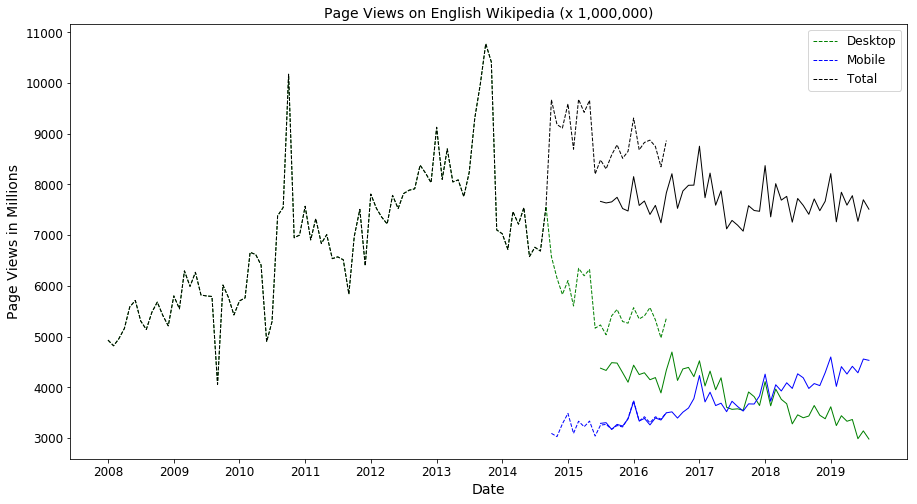

In [12]:
plt.rcParams["figure.figsize"] = [15, 8]

plt.plot("date", "pagecount_desktop_views", data=df[df["pagecount_desktop_views"] != 0], marker='', color='green', linewidth=1, label="Desktop", linestyle='dashed')
plt.plot("date", "pagecount_mobile_views", data=df[df["pagecount_mobile_views"] != 0], marker='', color='blue', linewidth=1, label="Mobile", linestyle='dashed')
plt.plot("date", "pagecount_all_views", data=df[df["pagecount_all_views"] != 0], marker='', color='black', linewidth=1, label="Total", linestyle='dashed')
plt.legend(fontsize=12)

plt.plot("date", "pageview_desktop_views", data=df[df["pageview_desktop_views"] != 0], marker='', color='green', linewidth=1)
plt.plot("date", "pageview_mobile_views", data=df[df["pageview_mobile_views"] != 0], marker='', color='blue', linewidth=1)
plt.plot("date", "pageview_all_views", data=df[df["pageview_all_views"] != 0], marker='', color='black', linewidth=1)

plt.xlabel("Date", fontsize=14)
plt.ylabel("Page Views in Millions", fontsize=14)
plt.xticks(sorted(pd.to_datetime((df.year).apply(str), format='%Y').unique()))
plt.tick_params(labelsize=12)
plt.title("Page Views on English Wikipedia (x 1,000,000)", fontsize=14)

plt.savefig(png_outfile)

**Note:** From May 2015, a new pageview definition took effect, which eliminated all crawler traffic. Solid lines mark new definition.